<a href="https://colab.research.google.com/github/fernandopersan/4EscolaBigData/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder com extração de características e classificação com SVM

Antes de iniciar a execução do código faça a seguinte alteração: Menu: **Ambiente de execução -> Alterar o tipo de ambiente de execução -> GPU**

In [1]:
import numpy as np
from PIL import Image

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D, Conv2DTranspose
from keras.models import load_model
from keras.datasets import cifar10

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

**Definição de parâmetros:**

In [2]:
batchSize = 32
numberEpochs = 10

A função **lowSampleDataset(X,Y)** apenas reduz a quantidade de exemplos para que a execução seja mais rápida em nosso exemplo!

In [3]:
def lowSampleDataset(X, Y):
    perm = np.random.permutation(X.shape[0])
    X = X[perm[0 : (int)(X.shape[0] * (5/100))]]
    Y = Y[perm[0 : (int)(Y.shape[0] * (5/100))]]
    return X, Y

**Pré-processamento:**

1.   Carregamos o dataset CIFAR10
2.   Reduzimos a quantidade de exemplos
1.   Alteramos a resolução dos exemplos




In [4]:
print("Loading CIFAR10 images ...")
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

Xtrain, Ytrain = lowSampleDataset(Xtrain, Ytrain)
Xtest, Ytest = lowSampleDataset(Xtest, Ytest)

print('\tTraining set shape: ', Xtrain.shape)
print('\tTesting set shape: ', Xtest.shape)

Loading CIFAR10 images ...
	Training set shape:  (2500, 32, 32, 3)
	Testing set shape:  (500, 32, 32, 3)


**Preparando o AutoEncoder:**

1.   Adicionamos as camadas desejadas
2.   Definimos a função de perda e o otimizador


In [5]:
print("Defining the AE ...")
input_img = Input(shape=(32, 32, 3,))

encoder = Conv2D(8, kernel_size=(3,3), strides=(2, 2), padding='same', activation='relu')(input_img)
encoder = Conv2D(8, kernel_size=(3,3), padding='valid', activation='relu')(encoder)
encoder = MaxPooling2D(pool_size=(2, 2))(encoder)
encoder = Flatten(name='code')(encoder)

decoder = Reshape((7,7,8))(encoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = Conv2DTranspose(8, kernel_size=(3,3), padding='valid', activation='relu')(decoder)
decoder = Conv2DTranspose(3, kernel_size=(3,3), strides=(2, 2), padding='same', activation='relu')(decoder)

autoencoder = Model(input_img, decoder)
autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

Defining the AE ...
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 8)           0         
_________________________________________________________________
code (Flatten)               (None, 392)               0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 8)           0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None

**Treinamento da rede:**

Após o treinamento geramos o gráfico com a loss

Training the AE ...
Epoch 1/10
79/79 [==============================] - 1s 18ms/step - loss: 9795.8516
Epoch 2/10
79/79 [==============================] - 1s 18ms/step - loss: 2832.6057
Epoch 3/10
79/79 [==============================] - 1s 18ms/step - loss: 1468.5160
Epoch 4/10
79/79 [==============================] - 1s 18ms/step - loss: 1219.1888
Epoch 5/10
79/79 [==============================] - 1s 18ms/step - loss: 1085.2235
Epoch 6/10
79/79 [==============================] - 1s 18ms/step - loss: 972.0002
Epoch 7/10
79/79 [==============================] - 1s 18ms/step - loss: 890.5311
Epoch 8/10
79/79 [==============================] - 1s 18ms/step - loss: 832.0901
Epoch 9/10
79/79 [==============================] - 1s 18ms/step - loss: 793.8523
Epoch 10/10
79/79 [==============================] - 1s 18ms/step - loss: 762.9573


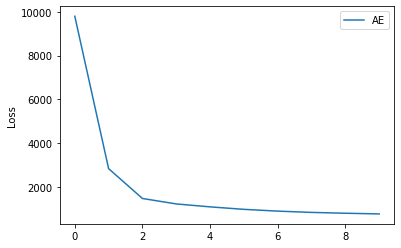

In [6]:
print("Training the AE ...")
historyAE = autoencoder.fit(x=Xtrain, y=Xtrain, batch_size=batchSize, epochs=numberEpochs, shuffle=True, verbose=1)

plt.plot(historyAE.history['loss'])
plt.ylabel('Loss')
plt.legend(['AE'], loc='upper right')
plt.show()

**Extração de características e classificação:**

A extração de características ocorre com a camada 'code', tanto para o conjunto de treinamento quanto para o conjunto de teste. Em seguida, SVM é utilizado para predizer os rótulos.

In [7]:
print("Feature extraction with AutoEncoder ...")
autoencoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(name='code').output)

prediction = np.array(autoencoder.predict(Xtrain))
Xtrain = np.reshape(prediction, (prediction.shape[0], prediction.shape[1]))

prediction = np.array(autoencoder.predict(Xtest))
Xtest = np.reshape(prediction, (prediction.shape[0], prediction.shape[1]))

print('\tFeatures training shape: ', Xtrain.shape)
print('\tFeatures testing shape: ', Xtest.shape)

svm = SVC(kernel='linear')
svm.fit(Xtrain, np.ravel(Ytrain, order='C'))
result = svm.predict(Xtest)

acc = accuracy_score(result, np.ravel(Ytest, order='C'))
print("\tAccuracy Linear SVM: %0.4f" % acc)

Feature extraction with AutoEncoder ...
	Features training shape:  (2500, 392)
	Features testing shape:  (500, 392)
	Accuracy Linear SVM: 0.3880
